<a href="https://colab.research.google.com/github/yilmajung/KM4D_v0/blob/main/ksp_model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KSP Knowledge Extraction: Model Comparison

Compare results from 3 LLMs on the same 112-chapter KSP extraction pipeline:

| Model | File | Provider |
|-------|------|----------|
| Claude Sonnet 4 | `chapter_analysis.json` | Anthropic API |
| Llama 3.1 8B | `chapter_analysis_llama.json` | Local (Colab T4 GPU) |
| Llama 3.1 70B | `chapter_analysis_llama70b.json` | Together AI API |

All 3 models processed the same 4 KSP reports (112 chapters) with the same prompt template.

## Section 1: Setup

In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Auto-detect Colab vs local
if os.path.exists('/content/drive/MyDrive/KM4D_v0/data/results'):
    RESULTS_DIR = '/content/drive/MyDrive/KM4D_v0/data/results'
else:
    RESULTS_DIR = 'data/results'

# Load all 3 result files
FILES = {
    'Claude Sonnet 4': 'chapter_analysis.json',
    'Llama 3.1 8B': 'chapter_analysis_llama.json',
    'Llama 3.1 70B': 'chapter_analysis_llama70b.json',
}

results = {}
for label, fname in FILES.items():
    path = os.path.join(RESULTS_DIR, fname)
    with open(path) as f:
        results[label] = json.load(f)
    print(f'{label}: {len(results[label])} entries loaded from {fname}')

MODEL_LABELS = list(FILES.keys())
COLORS = {'Claude Sonnet 4': '#6366f1', 'Llama 3.1 8B': '#f59e0b', 'Llama 3.1 70B': '#10b981'}

Claude Sonnet 4: 112 entries loaded from chapter_analysis.json
Llama 3.1 8B: 112 entries loaded from chapter_analysis_llama.json
Llama 3.1 70B: 112 entries loaded from chapter_analysis_llama70b.json


## Section 2: Overview & Reliability

In [5]:
# Summary statistics table
summary_rows = []
for model in MODEL_LABELS:
    data = results[model]
    total = len(data)
    valid = [d for d in data if 'error' not in d]
    errors = total - len(valid)
    success_rate = len(valid) / total * 100

    # Count policies (filter out placeholder "Not Applicable" entries)
    total_policies = 0
    chapters_with_policies = 0
    for d in valid:
        kp = d.get('korean_policies', 'Not Applicable')
        if isinstance(kp, list):
            real = [p for p in kp if p.get('policy_name') != 'Not Applicable']
            if real:
                total_policies += len(real)
                chapters_with_policies += 1

    # Count theories
    chapters_with_theories = sum(
        1 for d in valid
        if isinstance(d.get('related_theories'), list) and d['related_theories']
    )

    summary_rows.append({
        'Model': model,
        'Total Chapters': total,
        'Valid': len(valid),
        'Errors': errors,
        'Parse Success Rate': f'{success_rate:.1f}%',
        'Total Policies': total_policies,
        'Chapters w/ Policies': chapters_with_policies,
        'Chapters w/ Theories': chapters_with_theories,
    })

summary_df = pd.DataFrame(summary_rows)
print('=== Model Comparison Summary ===')
print()
print(summary_df.to_string(index=False))

=== Model Comparison Summary ===

          Model  Total Chapters  Valid  Errors Parse Success Rate  Total Policies  Chapters w/ Policies  Chapters w/ Theories
Claude Sonnet 4             112    112       0             100.0%             194                    75                   108
   Llama 3.1 8B             112     73      39              65.2%              83                    46                    73
  Llama 3.1 70B             112    109       3              97.3%              89                    50                   105


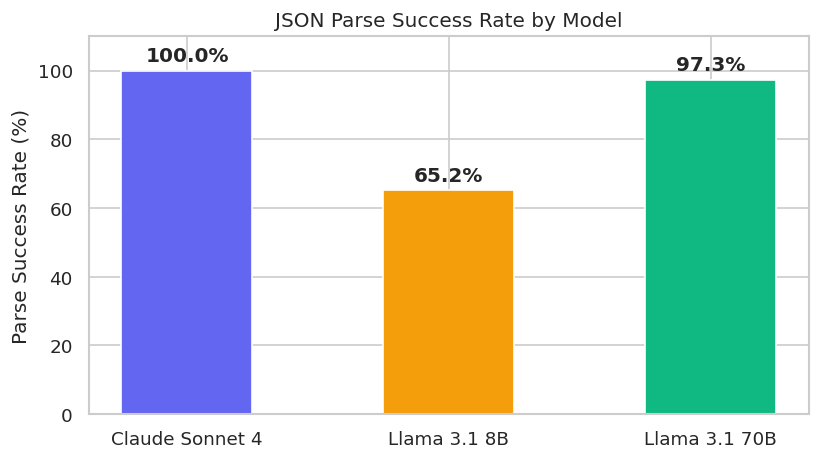

In [6]:
# Parse success rate bar chart
fig, ax = plt.subplots(figsize=(7, 4))
rates = [float(row['Parse Success Rate'].strip('%')) for row in summary_rows]
bars = ax.bar(MODEL_LABELS, rates, color=[COLORS[m] for m in MODEL_LABELS], width=0.5)
ax.set_ylabel('Parse Success Rate (%)')
ax.set_title('JSON Parse Success Rate by Model')
ax.set_ylim(0, 110)
for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
            f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

## Section 3: Sector Classification

In [7]:
# Sector normalization for Llama 8B
# The 8B model omits "(N)" prefixes and sometimes uses sub-sector L1 names as sector names.
# Build a lookup mapping every sub-sector name back to its parent sector.

TAXONOMY = {
    '(1) Economic Policy': {
        'Macroeconomic Policy & Stability': {},
        'Inclusive & Sustainable Growth': {},
        'Investment & Private Sector Dev.': {},
    },
    '(2) Social Services': {
        'Education': {},
        'Health': {},
        'Social Protection & Inclusion': {},
        'Cross-Cutting Social Issues': {},
    },
    '(3) Digital Innovation': {
        'Digital Policy & Governance': {},
        'Digital Infrastructure': {},
        'Digital Transformation': {},
        'Emerging Technologies': {},
    },
    '(4) Production & Trade': {
        'Agriculture, Forestry & Fisheries': {},
        'Industry & Services': {},
        'Trade Policy & Facilitation': {},
    },
    '(5) Infrastructure': {
        'Infrastructure Policy & Finance': {},
        'Transport': {},
        'Water & Sanitation': {},
        'Urban & Rural Development': {},
    },
    '(6) Energy & Environment': {
        'Environmental Policy & Management': {},
        'Climate Change': {},
        'Energy': {},
    },
}

SECTOR_NAMES = list(TAXONOMY.keys())  # canonical names with prefixes

# Build normalization lookup
_sector_lookup = {}
for sector, l1_dict in TAXONOMY.items():
    # Map unprefixed name -> canonical
    short_name = sector.split(') ', 1)[1] if ') ' in sector else sector
    _sector_lookup[short_name.lower()] = sector
    _sector_lookup[sector.lower()] = sector
    # Map every sub-sector L1 name -> parent sector
    for l1_name in l1_dict:
        _sector_lookup[l1_name.lower()] = sector


def normalize_sector(name: str) -> str:
    """Normalize a sector name to its canonical form with (N) prefix."""
    if not name:
        return 'Unknown'
    # Already canonical?
    if name in SECTOR_NAMES:
        return name
    # Lookup
    result = _sector_lookup.get(name.lower())
    if result:
        return result
    return f'Unknown ({name})'


# Test normalization
test_cases = [
    'Economic Policy',
    '(1) Economic Policy',
    'Inclusive & Sustainable Growth',
    'Investment & Private Sector Dev.',
    'Production & Trade',
    'Digital Innovation',
    'Energy & Environment',
]
print('Sector normalization test:')
for name in test_cases:
    print(f'  "{name}" -> "{normalize_sector(name)}"')

Sector normalization test:
  "Economic Policy" -> "(1) Economic Policy"
  "(1) Economic Policy" -> "(1) Economic Policy"
  "Inclusive & Sustainable Growth" -> "(1) Economic Policy"
  "Investment & Private Sector Dev." -> "(1) Economic Policy"
  "Production & Trade" -> "(4) Production & Trade"
  "Digital Innovation" -> "(3) Digital Innovation"
  "Energy & Environment" -> "(6) Energy & Environment"


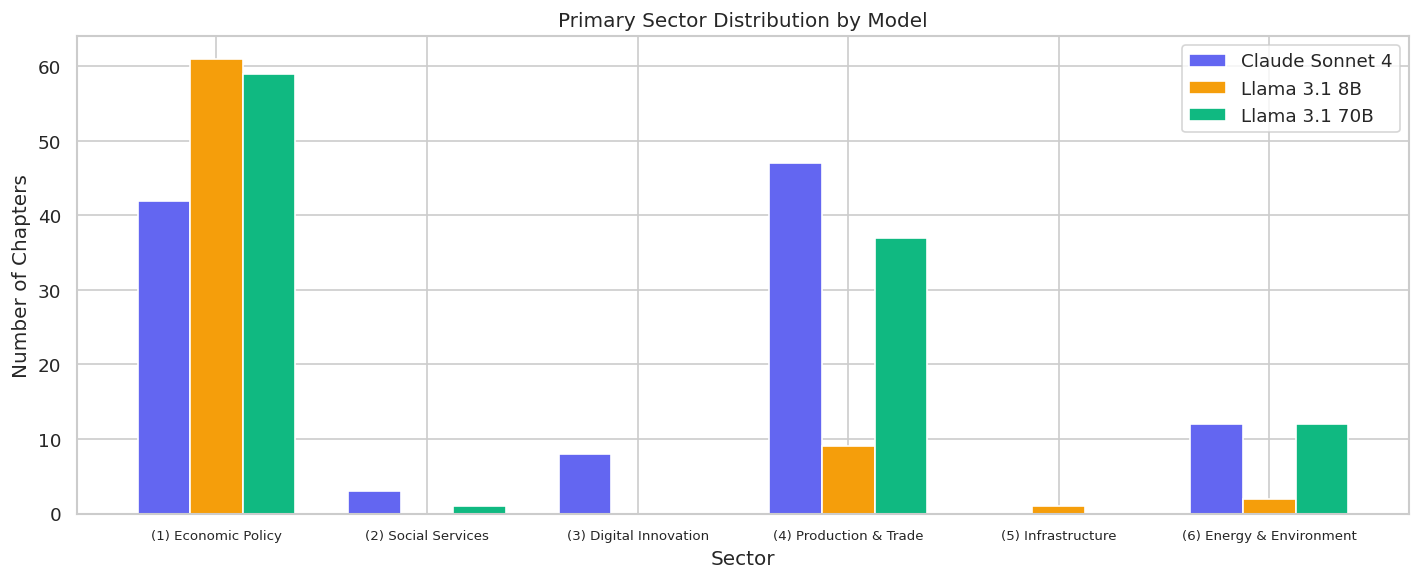

In [9]:
# Sector distribution across 3 models (grouped bar chart)
def get_sector_counts(data):
    counts = Counter()
    for d in data:
        if 'error' not in d:
            sectors = d['taxonomy_classification']['sectors']
            if sectors:
                primary = normalize_sector(sectors[0]['sector'])
                counts[primary] += 1
    return counts

sector_data = {model: get_sector_counts(results[model]) for model in MODEL_LABELS}

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(SECTOR_NAMES))
width = 0.25
for i, model in enumerate(MODEL_LABELS):
    counts = [sector_data[model].get(s, 0) for s in SECTOR_NAMES]
    ax.bar(x + i * width, counts, width, label=model, color=COLORS[model])

ax.set_xlabel('Sector')
ax.set_ylabel('Number of Chapters')
ax.set_title('Primary Sector Distribution by Model')
ax.set_xticks(x + width)
# Wrap long sector names
short_labels = [s.replace('(', '\n(').strip() for s in SECTOR_NAMES]
ax.set_xticklabels(short_labels, fontsize=8)
ax.legend()
plt.tight_layout()
plt.show()

In [10]:
# Chapter-level sector agreement
# Use (report_id, chapter_title, page_start) as key — title alone is not unique
# because sub-chapters like "1. Introduction" repeat within the same report.

def chapter_key(d):
    """Unique key for a chapter entry."""
    return (d['report_id'], d['chapter_title'], d['page_start'])

def get_chapter_sectors(data):
    """Return dict mapping chapter_key -> normalized primary sector."""
    mapping = {}
    for d in data:
        if 'error' not in d:
            key = chapter_key(d)
            sectors = d['taxonomy_classification']['sectors']
            if sectors:
                mapping[key] = normalize_sector(sectors[0]['sector'])
    return mapping

sector_maps = {model: get_chapter_sectors(results[model]) for model in MODEL_LABELS}

# Find chapters where ALL 3 models have valid results
common_keys = set.intersection(*[set(m.keys()) for m in sector_maps.values()])
print(f'Chapters with valid results from all 3 models: {len(common_keys)}')
print()

# Full agreement
full_agree = sum(
    1 for k in common_keys
    if len({sector_maps[m][k] for m in MODEL_LABELS}) == 1
)
print(f'Full agreement (all 3 match): {full_agree}/{len(common_keys)} ({full_agree/len(common_keys)*100:.1f}%)')

# Pairwise agreement
pairs = [
    ('Claude Sonnet 4', 'Llama 3.1 70B'),
    ('Claude Sonnet 4', 'Llama 3.1 8B'),
    ('Llama 3.1 70B', 'Llama 3.1 8B'),
]
for m1, m2 in pairs:
    agree = sum(1 for k in common_keys if sector_maps[m1][k] == sector_maps[m2][k])
    print(f'  {m1} vs {m2}: {agree}/{len(common_keys)} ({agree/len(common_keys)*100:.1f}%)')

Chapters with valid results from all 3 models: 70

Full agreement (all 3 match): 38/70 (54.3%)
  Claude Sonnet 4 vs Llama 3.1 70B: 60/70 (85.7%)
  Claude Sonnet 4 vs Llama 3.1 8B: 38/70 (54.3%)
  Llama 3.1 70B vs Llama 3.1 8B: 47/70 (67.1%)


## Section 4: Knowledge Type Classification

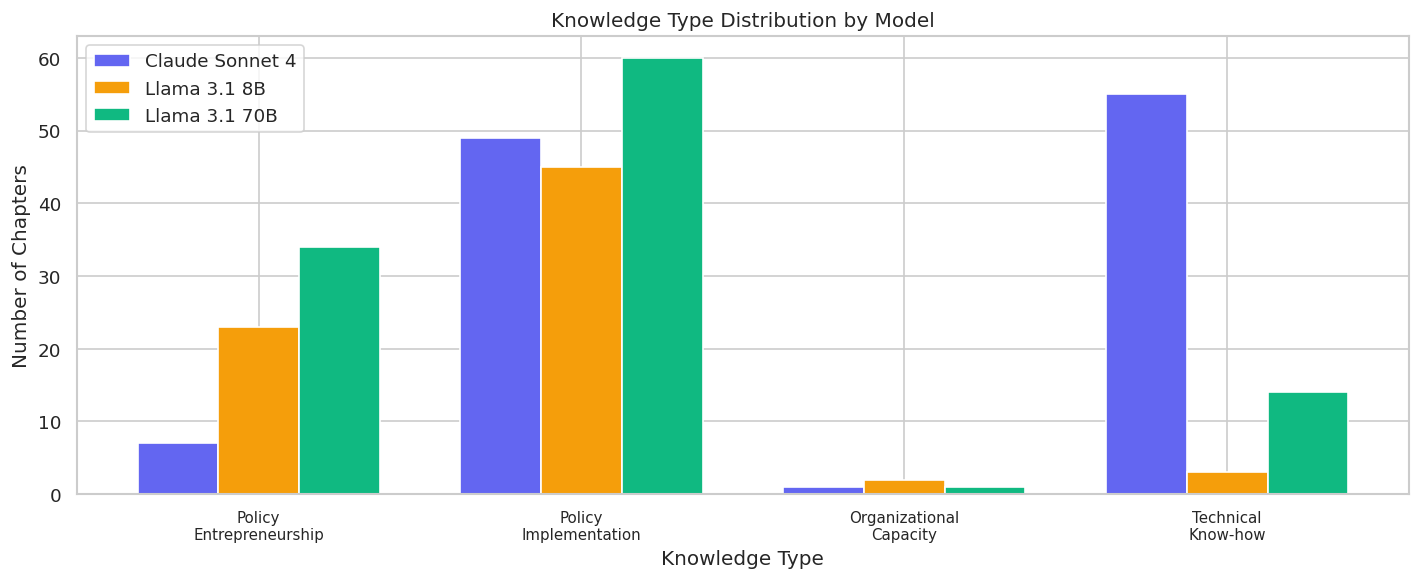

In [11]:
# Knowledge type distribution (grouped bar chart)
KNOWLEDGE_TYPES = [
    'Policy Entrepreneurship (leadership)',
    'Policy Implementation & Coordinating Mechanism',
    'Organizational/Individual Capacity',
    'Technical Know-how',
]

def get_kt_counts(data):
    counts = Counter()
    for d in data:
        if 'error' not in d:
            kt = d['taxonomy_classification']['knowledge_type']
            counts[kt] += 1
    return counts

kt_data = {model: get_kt_counts(results[model]) for model in MODEL_LABELS}

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(KNOWLEDGE_TYPES))
width = 0.25
for i, model in enumerate(MODEL_LABELS):
    counts = [kt_data[model].get(kt, 0) for kt in KNOWLEDGE_TYPES]
    ax.bar(x + i * width, counts, width, label=model, color=COLORS[model])

ax.set_xlabel('Knowledge Type')
ax.set_ylabel('Number of Chapters')
ax.set_title('Knowledge Type Distribution by Model')
ax.set_xticks(x + width)
# Shorter labels
kt_short = ['Policy\nEntrepreneurship', 'Policy\nImplementation', 'Organizational\nCapacity', 'Technical\nKnow-how']
ax.set_xticklabels(kt_short, fontsize=9)
ax.legend()
plt.tight_layout()
plt.show()

In [12]:
# Chapter-level knowledge type agreement
def get_chapter_kt(data):
    mapping = {}
    for d in data:
        if 'error' not in d:
            key = chapter_key(d)
            mapping[key] = d['taxonomy_classification']['knowledge_type']
    return mapping

kt_maps = {model: get_chapter_kt(results[model]) for model in MODEL_LABELS}
common_keys_kt = set.intersection(*[set(m.keys()) for m in kt_maps.values()])

full_agree_kt = sum(
    1 for k in common_keys_kt
    if len({kt_maps[m][k] for m in MODEL_LABELS}) == 1
)
print(f'Knowledge type agreement (all 3 match): {full_agree_kt}/{len(common_keys_kt)} ({full_agree_kt/len(common_keys_kt)*100:.1f}%)')

for m1, m2 in pairs:
    agree = sum(1 for k in common_keys_kt if kt_maps[m1][k] == kt_maps[m2][k])
    print(f'  {m1} vs {m2}: {agree}/{len(common_keys_kt)} ({agree/len(common_keys_kt)*100:.1f}%)')

Knowledge type agreement (all 3 match): 18/70 (25.7%)
  Claude Sonnet 4 vs Llama 3.1 70B: 31/70 (44.3%)
  Claude Sonnet 4 vs Llama 3.1 8B: 21/70 (30.0%)
  Llama 3.1 70B vs Llama 3.1 8B: 48/70 (68.6%)


## Section 5: Korean Policy Extraction

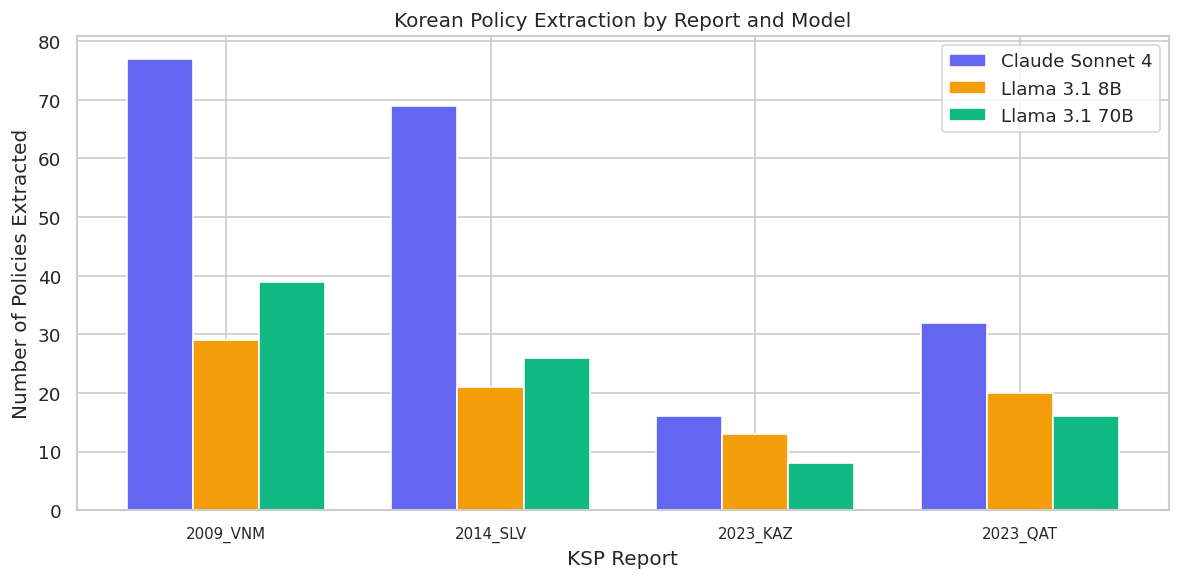

In [14]:
# Per-report policy count comparison
def get_policy_counts_by_report(data):
    counts = Counter()
    for d in data:
        if 'error' not in d:
            kp = d.get('korean_policies', 'Not Applicable')
            if isinstance(kp, list):
                real = [p for p in kp if p.get('policy_name') != 'Not Applicable']
                counts[d['report_id']] += len(real)
    return counts

policy_data = {model: get_policy_counts_by_report(results[model]) for model in MODEL_LABELS}

# Short report labels
all_reports = sorted({d['report_id'] for d in results[MODEL_LABELS[0]]})
report_short = {r: r[:8] for r in all_reports}  # e.g. "2009_VNM"

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(all_reports))
width = 0.25
for i, model in enumerate(MODEL_LABELS):
    counts = [policy_data[model].get(r, 0) for r in all_reports]
    ax.bar(x + i * width, counts, width, label=model, color=COLORS[model])

ax.set_xlabel('KSP Report')
ax.set_ylabel('Number of Policies Extracted')
ax.set_title('Korean Policy Extraction by Report and Model')
ax.set_xticks(x + width)
ax.set_xticklabels([report_short[r] for r in all_reports], fontsize=9)
ax.legend()
plt.tight_layout()
plt.show()

In [16]:
# Policy extraction: which chapters found policies by which models
def get_chapters_with_policies(data):
    chapters = set()
    for d in data:
        if 'error' not in d:
            kp = d.get('korean_policies', 'Not Applicable')
            if isinstance(kp, list):
                real = [p for p in kp if p.get('policy_name') != 'Not Applicable']
                if real:
                    chapters.add(chapter_key(d))
    return chapters

policy_chapters = {model: get_chapters_with_policies(results[model]) for model in MODEL_LABELS}

# Overlap analysis (using common valid chapters only)
common_valid = set.intersection(*[
    {chapter_key(d) for d in results[m] if 'error' not in d}
    for m in MODEL_LABELS
])

print(f'Common valid chapters: {len(common_valid)}')
print()

# Restrict to common chapters
pc_common = {m: policy_chapters[m] & common_valid for m in MODEL_LABELS}

for model in MODEL_LABELS:
    print(f'{model}: {len(pc_common[model])} chapters with policies (out of {len(common_valid)} common)')

print()

# All 3 found policies
all_found = set.intersection(*pc_common.values()) if all(pc_common.values()) else set()
print(f'All 3 models found policies: {len(all_found)} chapters')

# Only one model found policies
for model in MODEL_LABELS:
    others = [m for m in MODEL_LABELS if m != model]
    unique = pc_common[model] - set.union(*[pc_common[m] for m in others])
    print(f'Only {model} found policies: {len(unique)} chapters')

Common valid chapters: 70

Claude Sonnet 4: 41 chapters with policies (out of 70 common)
Llama 3.1 8B: 43 chapters with policies (out of 70 common)
Llama 3.1 70B: 33 chapters with policies (out of 70 common)

All 3 models found policies: 32 chapters
Only Claude Sonnet 4 found policies: 0 chapters
Only Llama 3.1 8B found policies: 2 chapters
Only Llama 3.1 70B found policies: 1 chapters


## Section 6: Theory Linking

In [17]:
# Theory linking rate by model
print('Theory Linking Summary')
print('=' * 60)
print()

theory_stats = []
for model in MODEL_LABELS:
    valid = [d for d in results[model] if 'error' not in d]
    with_theories = [
        d for d in valid
        if isinstance(d.get('related_theories'), list) and d['related_theories']
    ]
    total_theories = sum(
        len(d['related_theories']) for d in with_theories
    )
    avg = total_theories / len(with_theories) if with_theories else 0

    theory_stats.append({
        'Model': model,
        'Valid Chapters': len(valid),
        'Chapters w/ Theories': len(with_theories),
        'Linking Rate': f'{len(with_theories)/len(valid)*100:.1f}%',
        'Total Theories Cited': total_theories,
        'Avg Theories/Chapter': f'{avg:.1f}',
    })

print(pd.DataFrame(theory_stats).to_string(index=False))

Theory Linking Summary

          Model  Valid Chapters  Chapters w/ Theories Linking Rate  Total Theories Cited Avg Theories/Chapter
Claude Sonnet 4             112                   108        96.4%                   191                  1.8
   Llama 3.1 8B              73                    73       100.0%                   114                  1.6
  Llama 3.1 70B             109                   105        96.3%                   173                  1.6


## Section 7: Chapter-Level Detail

In [18]:
# Side-by-side comparison for a sample of chapters
# Pick 10 chapters spread across reports where all 3 models have results

# Build lookup by chapter key
lookups = {}
for model in MODEL_LABELS:
    lookups[model] = {}
    for d in results[model]:
        if 'error' not in d:
            key = chapter_key(d)
            lookups[model][key] = d

common = sorted(common_valid)
# Sample evenly: pick every Nth chapter
step = max(1, len(common) // 10)
sample_keys = common[::step][:10]

rows = []
for key in sample_keys:
    report_id, chapter_title, page_start = key
    row = {
        'Report': report_id[:8],
        'Chapter': chapter_title[:50],
    }
    for model in MODEL_LABELS:
        d = lookups[model][key]
        sectors = d['taxonomy_classification']['sectors']
        primary_sector = normalize_sector(sectors[0]['sector']) if sectors else 'N/A'
        # Short sector label (just the number)
        sector_short = primary_sector.split(')')[0] + ')' if '(' in primary_sector else primary_sector
        kt = d['taxonomy_classification']['knowledge_type']
        # Abbreviate knowledge type
        kt_abbrev = {
            'Policy Entrepreneurship (leadership)': 'Entrepreneurship',
            'Policy Implementation & Coordinating Mechanism': 'Implementation',
            'Organizational/Individual Capacity': 'Org. Capacity',
            'Technical Know-how': 'Technical',
        }.get(kt, kt)

        kp = d.get('korean_policies', 'Not Applicable')
        if isinstance(kp, list):
            n_policies = len([p for p in kp if p.get('policy_name') != 'Not Applicable'])
        else:
            n_policies = 0

        short_model = model.split()[-1]  # "4", "8B", "70B"
        row[f'{short_model} Sector'] = sector_short
        row[f'{short_model} KT'] = kt_abbrev
        row[f'{short_model} Pol'] = n_policies

    rows.append(row)

detail_df = pd.DataFrame(rows)
print('=== Side-by-Side Chapter Comparison (sample of 10) ===')
print()
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.width', 200)
print(detail_df.to_string(index=False))

=== Side-by-Side Chapter Comparison (sample of 10) ===

  Report                                            Chapter 4 Sector           4 KT  4 Pol 8B Sector            8B KT  8B Pol 70B Sector           70B KT  70B Pol
2009_VNM                              01. Executive Summary      (1) Implementation      2       (1)   Implementation       2        (1)   Implementation        2
2009_VNM                                    1. Introduction      (4)      Technical      1       (1) Entrepreneurship       1        (1) Entrepreneurship        1
2009_VNM       3. Capital Account Liberalization in Vietnam      (1)      Technical      0       (1)   Implementation       0        (1)   Implementation        0
2009_VNM 4. Early Warning System for Financial Institutions      (1)      Technical      2       (1)   Implementation       2        (1)   Implementation        2
2009_VNM                   5. Conclusion and Policy Lessons      (3) Implementation      3       (1) Entrepreneurship       1    

## Section 8: Summary & Recommendations

In [19]:
# Print summary findings
print('=' * 70)
print('MODEL COMPARISON SUMMARY')
print('=' * 70)
print()

# 1. Reliability
print('1. RELIABILITY')
print('-' * 40)
for row in summary_rows:
    print(f"   {row['Model']}: {row['Parse Success Rate']} parse success ({row['Errors']} errors)")
print()

# 2. Sector agreement
print('2. SECTOR CLASSIFICATION AGREEMENT')
print('-' * 40)
print(f'   Full agreement (all 3): {full_agree}/{len(common_keys)} ({full_agree/len(common_keys)*100:.1f}%)')
for m1, m2 in pairs:
    agree = sum(1 for k in common_keys if sector_maps[m1][k] == sector_maps[m2][k])
    print(f'   {m1} vs {m2}: {agree/len(common_keys)*100:.1f}%')
print()

# 3. Knowledge type agreement
print('3. KNOWLEDGE TYPE AGREEMENT')
print('-' * 40)
print(f'   Full agreement (all 3): {full_agree_kt}/{len(common_keys_kt)} ({full_agree_kt/len(common_keys_kt)*100:.1f}%)')
for m1, m2 in pairs:
    agree = sum(1 for k in common_keys_kt if kt_maps[m1][k] == kt_maps[m2][k])
    print(f'   {m1} vs {m2}: {agree/len(common_keys_kt)*100:.1f}%')
print()

# 4. Key differences
print('4. KEY DIFFERENCES')
print('-' * 40)
print('   - Knowledge type skew: Sonnet favors "Technical Know-how",'
      ' Llama models favor "Policy Implementation"')
print(f'   - Policy extraction volume: Sonnet ({summary_rows[0]["Total Policies"]}) >>'
      f' 70B ({summary_rows[2]["Total Policies"]}) > 8B ({summary_rows[1]["Total Policies"]})')
print(f'   - 8B reliability: only {summary_rows[1]["Parse Success Rate"]} parse success'
      ' (JSON formatting issues)')
print()

# 5. Recommendations
print('5. RECOMMENDATIONS')
print('-' * 40)
print('   - Claude Sonnet 4: Best reliability and richest extraction.')
print('     Recommended for production pipeline.')
print('   - Llama 3.1 70B: Good reliability (97.3%), reasonable extraction.')
print('     Viable open-source alternative with structured output tuning.')
print('   - Llama 3.1 8B: Too many parse failures for production use.')
print('     Needs structured output enforcement or fine-tuning.')

MODEL COMPARISON SUMMARY

1. RELIABILITY
----------------------------------------
   Claude Sonnet 4: 100.0% parse success (0 errors)
   Llama 3.1 8B: 65.2% parse success (39 errors)
   Llama 3.1 70B: 97.3% parse success (3 errors)

2. SECTOR CLASSIFICATION AGREEMENT
----------------------------------------
   Full agreement (all 3): 38/70 (54.3%)
   Claude Sonnet 4 vs Llama 3.1 70B: 85.7%
   Claude Sonnet 4 vs Llama 3.1 8B: 54.3%
   Llama 3.1 70B vs Llama 3.1 8B: 67.1%

3. KNOWLEDGE TYPE AGREEMENT
----------------------------------------
   Full agreement (all 3): 18/70 (25.7%)
   Claude Sonnet 4 vs Llama 3.1 70B: 44.3%
   Claude Sonnet 4 vs Llama 3.1 8B: 30.0%
   Llama 3.1 70B vs Llama 3.1 8B: 68.6%

4. KEY DIFFERENCES
----------------------------------------
   - Knowledge type skew: Sonnet favors "Technical Know-how", Llama models favor "Policy Implementation"
   - Policy extraction volume: Sonnet (194) >> 70B (89) > 8B (83)
   - 8B reliability: only 65.2% parse success (JSON forma